# Monthly dataset production

This notebook outlines the workflow for creating a monthly NEE dataset. You first need to have run the CarbonTracker workflow to train and create the model. 

To create the dataset you need:

- CarbonTracker model
- ERA5 (monthly)
- ERA5-land (monthly)
- SPEI (monthly)
- MODIS (monthly)
- Biomass (yearly)
- Copernicus Landcover (yearly)


In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import xarray as xr
from dask.distributed import Client

import excited_workflow
from excited_workflow import produce_carbontracker_dataset


client = Client()

First define the paths where the input data and trained model is located. 

In [2]:
home_path = Path.home()
data_dir = home_path / "data/volume_2" # Directory where data is located
model_dir = Path("/home/cdonnelly/carbon_tracker-2024-02-28_14_20") # Directory where model is located

carbontracker_file= data_dir / "EXCITED_prepped_data/CT2022.flux1x1-monthly.nc" # CarbonTracker file
regions_file = data_dir / "EXCITED_prepped_data/regions.nc" # File of regions
model_name = "lightgbm.onnx"

Produce monthly NEE dataset from CarbonTracker data. 

In [3]:
produce_carbontracker_dataset.produce_dataset(model_dir, model_name, carbontracker_file, regions_file, data_dir)

To demonstrate the results, we can open the monthly dataset and plot it against the original CarbonTracker data.

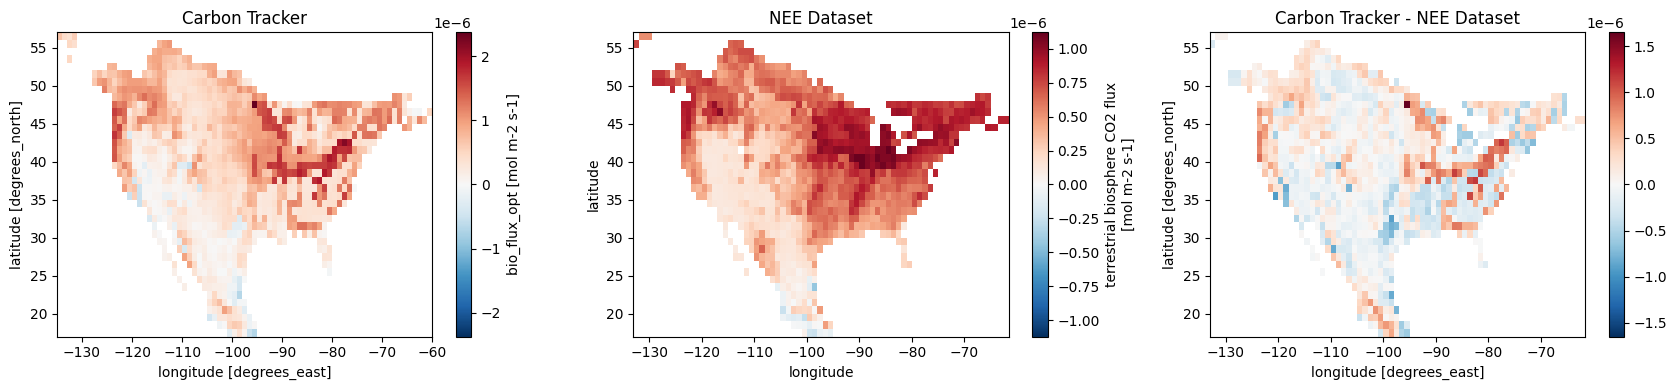

In [9]:
# Load produced dataset
NEE_dataset = xr.open_dataset(data_dir / "NEE/CarbonTracker/NEE_monthly.nc")

# Load CarbonTracker and regions datasets and mask to same region
ds_cb = xr.open_dataset(carbontracker_file)
ds_cb = excited_workflow.utils.convert_timestamps(ds_cb)
ds_regions = xr.open_dataset(regions_file)

ds_merge = xr.merge([ds_cb, ds_regions["transcom_regions"]])
ds_na = ds_merge.where(ds_merge["transcom_regions"] == 2)
time_region_na = {
    "time": "2019-11-01",
    "latitude": slice(17, 57),
    "longitude": slice(-135, -60),
}

diff = ds_na["bio_flux_opt"] - NEE_dataset["bio_flux"]

fig, axs = plt.subplots(1,3, figsize = (17, 4))
ds_na["bio_flux_opt"].sel(time_region_na).plot(ax=axs[0])
axs[0].set_title("Carbon Tracker")
NEE_dataset["bio_flux"].sel(time_region_na).plot(ax=axs[1])
axs[1].set_title("NEE Dataset")
diff.sel(time_region_na).plot(ax=axs[2])
axs[2].set_title("Carbon Tracker - NEE Dataset")
plt.tight_layout()